# Tutorial 1: Regression

👋 Welcome to the first tutorial!

Today we discussed the **key concepts** of ML, as encapsulated in our graphic.

<img src="../figures/ml-key-ideas.jpg" width=400>

In particular, we were focusing on **supervised learning** where we have labeled datapoints, $(x,y)$, where $x^{(i)} \in \mathbb{R}^d$ are the data examples, and $y^{(i)}$ are the labels.

In this tutorial, we'll implement each of the boxes in is graphic for a **regression problem**, namely the housing prices dataset that we discussed in the lecture.

**Table of contents:**
- <span style="color:dimgray"> **Q1:** Data visualization </span>
- <span style="color:purple"> **Q2:** Hypothesis class: linear models  </span>
- <span style="color:blue"> **Q3:** Loss function, MSE </span>
- <span style="color:turquoise"> **Q4:** Learning (fitting the model) </span>
- <span style="color:gold"> **Q5:** Analysis of results</span>

**Step 0:** Download the dataset

In [1]:
# # If kagglehub not in your local env, download it here
# !pip install kagglehub

In [2]:
# imports
import kagglehub
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Download the dataset 
dataDir = '../data/'
fname = f'{dataDir}/Housing.csv'

if not os.path.exists(fname):
    # Download the dataset
    path = kagglehub.dataset_download("yasserh/housing-prices-dataset")
    print("Path to dataset files:", path)
    
    # Move the file to my data folder
    os.system(f'mv {path}/Housing.csv {dataDir}/.')
else:
    print(fname, 'already downloaded')


../data//Housing.csv already downloaded


### <span style="color:dimgray"> 1. Data visualization </span>

Let's open up the file and see what's inside!


In [4]:
df = pd.read_csv(fname)
df.index = np.arange(1,len(df)+1) # reset the index to start from 1

x_cols = df.columns[1:]

In [5]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
1,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
2,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
3,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
4,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
5,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [6]:
len(df)

545

OK, for a regression problem, the target $y$ is the `price`, and the other columns in the df (`area`, `bedrooms`, ...) are the **features** for our data $x$.

How to represent? Let $x \in \mathbb{R}^{12}$, where $x_1 = \mathrm{area}$, $x_2 = \mathrm{bedrooms}$, ...

There are 545 entries in this dataset.

In [7]:
# Note, there's been quite some inflation, so let's represnet the labels in units of $1M.
df['price ($1M)'] = df['price'] / int(1e6)

**EDA:** Event Data Analysis

Reproduced below are some of plots that we already saw in the lecture today.

Text(0.5, 1.0, 'Target labels $y$')

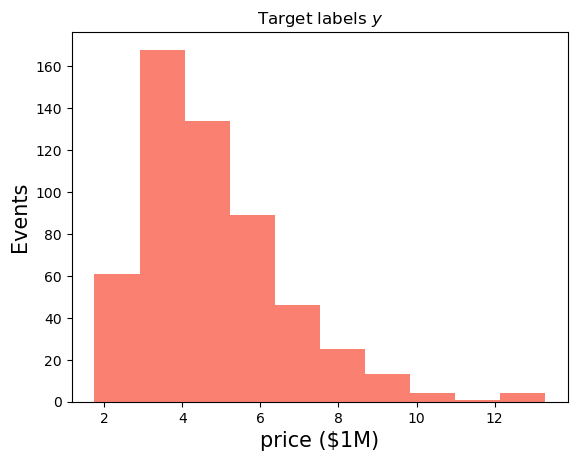

In [8]:
col = 'price ($1M)'

plt.hist(df[col],color='salmon')
plt.xlabel(col,fontsize=15)
plt.ylabel('Events',fontsize=15)
plt.title('Target labels $y$')

**Next:** Correlation between the input features $x_j$ and the labels $y$.

Let's look at the variables we want to fit!

I showed you in lecture already the correlation b/w housing area and price.

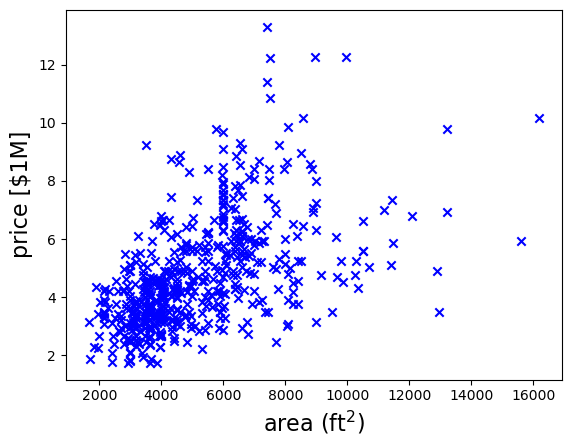

In [9]:
plt.scatter(df['area'],df['price ($1M)'],marker='x',color='b')
plt.xlabel('area (ft$^2$)',fontsize=16)
plt.ylabel('price [$1M]',fontsize=16)
plt.show()

**Q1: Your turn:** plot the rest of the input features.

**Potentially useful numpy / pandas dataframes functions:**
- `np.where`
- df[`col_name`].unique()

<span style="color:blue"> **Soln:** As visualized below, we have some different features, but also interesingly, we have some features that _aren't_ represented as integers already, e.g, `mainroad`, `guestroom`, `hotwaterheating`, `airconditioning`, `prefarea` are all booleans (yes / no).
</span>

In [10]:
'''
SOLN
'''
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price ($1M)
1,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished,13.300
2,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished,12.250
3,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished,12.250
4,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished,12.215
5,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished,11.410


<span style="color:blue"> **Soln:** And `furnishing status` is a categorical variable (three options eist).
</span>

In [11]:
df['furnishingstatus'].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

<span style="color:blue"> **Soln:** Represent boolean variables as (0,1) and the categorical variable as (0,1,2).
</span>

In [12]:
'''
SOLN: Demonstrating how to code up this categorical variable
'''

x_cat = np.zeros_like(df['furnishingstatus'])

for k, case in enumerate(df['furnishingstatus'].unique()):
    print(k,case)

    x_cat[df['furnishingstatus']==case] = k

print(x_cat)

0 furnished
1 semi-furnished
2 unfurnished
[0 0 1 0 0 1 1 2 0 2 0 1 1 0 1 1 2 0 0 1 1 2 0 0 0 0 1 1 2 1 2 1 0 2 0 0 0
 0 2 1 0 0 2 1 0 1 0 0 2 1 2 2 0 1 1 2 1 0 1 0 1 1 0 0 0 0 0 2 0 0 1 2 2 0
 0 1 0 0 0 0 1 1 0 1 1 0 2 1 2 0 1 0 0 1 1 1 0 1 2 2 2 2 1 0 0 2 1 2 1 1 1
 2 0 0 0 1 2 0 0 1 0 1 1 0 0 1 2 2 0 1 2 1 1 2 1 2 2 1 1 0 2 1 1 2 0 0 1 1
 1 1 2 1 0 1 1 0 1 0 1 0 0 1 1 1 0 2 2 1 0 1 1 1 2 2 2 1 0 1 1 1 1 0 1 1 0
 2 0 1 2 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 2 1 0 1 1 2 2 1 0 1 2 1 1
 1 0 2 1 1 0 1 1 1 1 0 2 1 1 1 1 1 0 1 1 0 0 1 2 1 2 1 0 1 1 1 0 1 2 0 0 1
 0 0 1 1 1 1 1 2 1 1 2 0 1 1 0 1 0 1 1 1 0 2 0 2 0 0 1 0 2 2 1 1 2 1 2 1 1
 1 2 1 0 1 1 2 0 1 1 1 1 1 1 1 1 0 1 1 1 2 2 1 1 0 1 0 1 1 1 2 1 1 0 2 0 1
 1 0 0 1 2 1 0 1 1 0 1 1 1 1 2 1 1 1 1 2 0 0 0 0 0 1 2 1 1 0 1 1 0 0 2 1 0
 1 1 1 0 1 2 1 2 1 2 1 1 0 0 0 2 2 1 2 1 2 1 1 2 2 2 1 0 2 1 2 2 2 2 2 2 2
 0 2 2 2 0 2 2 2 0 2 0 2 1 2 2 2 2 1 0 0 0 2 2 2 2 0 1 1 2 0 2 1 2 2 2 2 2
 0 0 2 1 1 2 1 1 1 2 2 2 1 2 2 2 2 2 1 2 1 2 1 1 1 0 2 2 

In [13]:
x_cols

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
       'furnishingstatus'],
      dtype='object')

In [14]:
'''
SOLN
'''

# Initialize an array to hold our ata
n = len(df)
d = len(x_cols)

X_feat = np.zeros((n,d))

real_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
bool_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
cat_vars = ['furnishingstatus']


In [15]:
for i,col in enumerate(x_cols):
    
    if col in real_vars:   
        X_feat[:,i] = df[col]

    elif col in bool_vars:
        X_feat[:,i] = np.where(df[col]=='yes',1,0)

    elif col in cat_vars:
        
        for k, case in enumerate(df[col].unique()):
            X_feat[df[col]==case,i] = k

In [16]:
X.shape

NameError: name 'X' is not defined

**Visualize first as a 1d histograms.**


In [ ]:
fig, axs = plt.subplots(3,4,figsize=(16,10),gridspec_kw={'hspace':.4,'wspace':.5})

'''
TO DO: Your code here
'''
for i, col, ax in zip(np.arange(d),x_cols,axs.flatten()):

    ax.hist(X_feat[:,i],color='lightskyblue')
    ax.set_xlabel(col)
    ax.set_ylabel('Entries')

plt.show()

**Next, visualize the correlations with target $y$**


In [ ]:
y = df['price ($1M)'].values
y[:10]

In [ ]:
fig, axs = plt.subplots(3,4,figsize=(16,9),gridspec_kw={'hspace':.4,'wspace':.5})

'''
TO DO: Your code here
'''
for i, col, ax in zip(np.arange(d),x_cols,axs.flatten()):

    ax.scatter(X_feat[:,i],y,color='lightskyblue')
    ax.set_xlabel(col)
    ax.set_ylabel('price ($1M)')

plt.show()

### <span style="color:purple"> 2. Hypothesis class: linear models  </span>

OK, nice we can see each of these input features have some correlation with the price.

**Next:** We want to code this up!

$$f(x; w) = w^T x, \quad \mathrm{where} \ w,x \in \mathbb{R}^{(d+1) \times 1}$$

as we now wish to the bias to the feature vector $x = \left[1, x_1, x_2, \ldots, x_d \right]^T$.

As suggested in the lecture, we'd like to work with _matrices_ now, so write the data vector in the form:

$$X =  \begin{pmatrix}
- x^{(1)} - \\ \vdots \\ - x^{(n)} - 
\end{pmatrix} \in \mathbb{R}^{n \times {(d+1)}}$$

So then to eval $f$ over the data _matrix_ our model becomes:

$$f(X;w) = X w \ \in \mathbb{R}^{n \times 1}$$


In [ ]:
X_feat.shape

In [ ]:
# Adding the bias to the feature vector

X = np.column_stack([np.ones(n),X_feat])
assert X.shape == (n, d+1)

In [ ]:
def f(X,w):

    '''
    TO DO: Your code here
    '''
    return X @ w
    

In [ ]:
'''
TO DO: Implement the dimension for w and test your 
'''
# w = np.zeros # FILL IN DIMS

'''
SOLN 
'''
w0 = np.zeros((d+1,1))

f(X,w0).shape # willl test your code

### <span style="color:blue"> 3. Loss function, MSE </span>

For a **regression** target we train with the **mean squared errror**

For linear models, we worked through the _closed form_ solution:

$w^* = (X^T X)^{-1} X y$

**TO DO:** Code this up!


In [ ]:
def w_star(X,y):

    '''
    TO DO: Your code here
    '''

    # Soln
    return np.linalg.inv(X.T @ X) @ X.T @ y
    

### <span style="color:turquoise"> 4. Learning (fitting the model) </span>

OK, let's test the model out!!

In [ ]:
# Sanity check the code works
w_fit = w_star(X,y)
w_fit

**What's the minimum value of this loss function??**

In [ ]:
y_pred = f(X,w_fit)
y_pred[:10]

In [ ]:
def mse(y,y_pred):
    '''
    TO DO: fill in
    '''
    return np.sum((y_pred-y)**2) / n

In [ ]:
L_min = mse(y,y_pred)
L_min

If we perturb `w_fit` just a little bit, is the loss **bigger** or smaller?

In [ ]:
w_pert = w_fit + 0.001*np.random.randn(d+1)
w_pert

In [ ]:
y_pert = f(X,w_pert)

L_alt = mse(y,y_pert)
L_alt

In [ ]:
assert L_min < L_alt # If this isn't satisfied, smth went wrong!

### <span style="color:gold"> 5. Analysis of results</span>


As this tutorial was already a bit long, this is a **bonus section!**

How performant are linear models with fewer features?

**TO DO:** For _each_ of the $d$ features, fit a linear model 

In [ ]:
fig, axs = plt.subplots(3,4,figsize=(16,9),gridspec_kw={'hspace':.4,'wspace':.5})

'''
TO DO: Your code here
'''
for i, col, ax in zip(np.arange(d),x_cols,axs.flatten()):

    ax.scatter(X_feat[:,i],y,color='lightskyblue')

    '''
    TO DO: Implement your code here
    '''
    
    # Define Xi
    Xi = np.column_stack([np.ones(n),X_feat[:,i]])    

    # Fit the best fit w
    wi = w_star(Xi,y)
    
    # Look at a prediciton
    xlim = ax.get_xlim()
    xx = np.linspace(*xlim)

    yy = f(np.column_stack([np.ones_like(xx),xx]),wi)
    ax.plot(xx,yy,color='r',ls=':')
    
    ax.set_xlabel(col)
    ax.set_ylabel('price ($1M)')
    ax.set_title(f'Loss: {mse(y, f(Xi,wi)):.3f}')
    
plt.show()

<span style="color:blue">  **Key take-away:**</span> 
- <span style="color:blue">The ``most informative'' input feature is `area` (the house size in ft$^2$), b/c using this feature alone gives the lowest loss.</span> 
- <span style="color:blue"> However, we get the lowest loss when combining _all_ the input features(!) </span> 

Note, the linear model that we set up today, doesn't include correlations in the input features.

We could have included them ``by hand'' by addition additional terms for the feature correlation, e.g, adding a dimensions like 

`area` x `bedrooms`.

This careful process of _defining_ which variables to include into a model is called **feature engineering**, but tomorrow, we'll see how neural networks can automatically _learn_ how to create useful features.

**Word of caution:** The purpose for this notebook was to understand linear models, MSE loss function, and implementing in code the formuas we derived.

However, in our solution, we're writing the whole notebook both fitting and predicting the performance on the training dataset, instead of splitting into a train, val and test set.

We'll leave as an exercise to the student to revise the notebook for the train, val, test sets